#Clasificador basado en redes neuronales

#**1-Montamos y cargamos los datos**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive/')
df_train = pd.read_csv('/content/drive/MyDrive/Ignieria_Linguistica/entrenamiento.csv')
df_test  = pd.read_csv('/content/drive/MyDrive/Ignieria_Linguistica/test.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#**2-Extracción terminológica: vector TF-IDF**
Una vez más vamos a crear la matriz TF-IDF sobre los datos de entrenamiento.

**2.1-Creamos la matriz tf-idf a partir del 75% de los documentos y transformamos los 25% restantes.**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(df_train.iloc[:, 0])
x_test_tfidf  = tfidf.transform(df_test.iloc[:, 0])

print(x_train_tfidf.shape, x_test_tfidf.shape)

(135, 14347) (45, 14347)


**2.2-Reducimos la dimensionalidad de nuestras características de entrada para el clasificador mediante SVD.**

**SVD o Single Value Decomposition** es una técnica de reducción de dimensión para matrices. Además este método funciona mejor con datos dispersos, es decir, datos con muchos valores a cero. Este es justo el caso en el que nos encontramos, se puede ver en la matriz de la celda anterior que la mayoría de valores de las palabras es 0, esto es debido a que muchas de ellas no aparecen en gran cantidad de documentos de nuestro corpus, por lo que al hacer $TF · IDF$ siendo IDF 0, se obtienen gran cantidad.

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
x_train_svd = svd.fit_transform(x_train_tfidf)
x_test_svd  = svd.transform(x_test_tfidf)

print(x_train_svd.shape, x_test_svd.shape)

(135, 100) (45, 100)


**2.3-Obtenemos y_train en formato One hot encoder**, ya que las redes neuronales funcionan mejor en formatos de [0-1]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
y_train_oh  = onehotencoder.fit_transform(df_train.iloc[:,1].values.reshape(-1,1)).toarray()

#**3-Creación y entrenamiento del modelo**

**3.1-Estructura del modelo**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from keras.layers.core import Activation

def build_model(x_train=x_train_svd, y_train=y_train_oh):
    model = Sequential()
    model.add(Dense(256, input_dim=x_train.shape[1], activation='relu', name='Densa_1'))
    model.add(Dropout(0.3, name='Dropout_1'))
    model.add(Dense(200, activation='relu', name='Densa_2'))
    model.add(Dropout(0.3, name='Dropout_2'))
    model.add(Dense(160, activation='relu', name='Densa_3'))
    model.add(Dropout(0.3, name='Dropout_3'))
    model.add(Dense(120, activation='relu', name='Densa_4'))
    model.add(Dropout(0.3, name='Dropout_4'))
    model.add(Dense(80, activation='relu', name='Densa_5'))
    model.add(Dropout(0.3, name='Dropout_5'))
    model.add(Dense(y_train_oh.shape[1], activation='softmax', name='Salida_Densa'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model



#model = build_model()
#plot_model(model, to_file='/content/drive/MyDrive/Ignieria_Linguistica/estructura_modelo.png', show_shapes=True)

**3.2-Creación y entrenamiento del modelo con las mismas condiciones que en SVM, 75% de datos de entrenamiento y 25% de test, no tenemos datos de desarrollo.** 

In [ ]:
clf = build_model()
history = clf.fit(x_train_svd, y_train_oh, epochs=150, batch_size=1, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Densa_1 (Dense)             (None, 256)               25856     
                                                                 
 Dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Densa_2 (Dense)             (None, 200)               51400     
                                                                 
 Dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 Densa_3 (Dense)             (None, 160)               32160     
                                                                 
 Dropout_3 (Dropout)         (None, 160)               0         
                                                                 
 Densa_4 (Dense)             (None, 120)              

**3.3-Guardamos el modelo para no tener que volver a entrenarlo**

In [ ]:
clf.save('/content/drive/MyDrive/Ignieria_Linguistica/modelo_NN/modelo.h5')

3.3.1-En caso de querer cargar el modelo:

In [ ]:
from keras.models import load_model
clf = load_model('/content/drive/MyDrive/Ignieria_Linguistica/modelo_NN/modelo.h5')

**3.4-Predicción probabilística, la guardamos en un excel**

In [ ]:
predicciones_prob = clf.predict(x_test_svd)
predicciones_rounded = [np.round(x,2) for x in predicciones_prob]
print(len(predicciones_rounded))
#predicciones_rounded
df_predicciones = pd.DataFrame(predicciones_rounded)
df_predicciones.columns=['Salud', 'Politica', 'Deportes']
df_predicciones.index.name = 'Documento'
df_predicciones.to_excel('/content/drive/MyDrive/Ignieria_Linguistica/modelo_NN/predicciones.xlsx')
predicciones_rounded

45


[array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 

#4-Evaluación del modelo ya entrenado

**4.1-Generamos un informe de la precisión, recall, f1-score y support del modelo sobre los datos de test. Lo guardamos en un excel**

In [ ]:
predicciones = clf.predict(x_test_svd)
predicciones = [np.argmax(x) for x in predicciones]

from sklearn.metrics import classification_report
target_names = ['Salud', 'Politica', 'Deportes']
informe = classification_report(y_test, predicciones, target_names=target_names, digits=3)
print(classification_report(y_test, predicciones, target_names=target_names, digits=3))


informe = classification_report(y_test, predicciones, target_names=target_names, digits=3, output_dict=True)
df_informe = pd.DataFrame(informe).transpose()
df_informe.to_excel('/content/drive/MyDrive/Ignieria_Linguistica/modelo_NN/informe.xlsx', index=True)

              precision    recall  f1-score   support

       Salud      1.000     1.000     1.000        15
    Politica      1.000     0.933     0.966        15
    Deportes      0.938     1.000     0.968        15

    accuracy                          0.978        45
   macro avg      0.979     0.978     0.978        45
weighted avg      0.979     0.978     0.978        45



**4.2-Generamos una matriz de confusión sobre los datos de test**

Precisión de las clasificaciones: 0.978


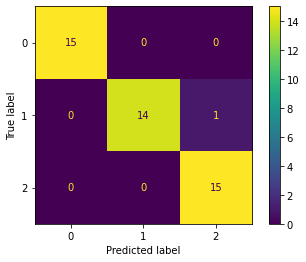

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
predicciones = clf.predict(x_test_svd)
predicciones = [np.argmax(x) for x in predicciones]
ConfusionMatrixDisplay.from_predictions(y_test, predicciones)
print("Precisión de las clasificaciones:", round(accuracy_score(y_test, predicciones),3))

Esta matriz de confusión nos muestra que:


1.   **De** los **15** documentos de **salud**, **15** han sido correctamente clasificado.
2.   **De** los **15** documentos de **política**, **14** han sido correctamente clasificado.
3.   **De** los **15** documentos de **deportes**, **15** han sido correctamente clasificado.


**Como conclusión podemos extraer que esta aproximación mejora ligeramente la aproximación con glasorias con supervisación.**